In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from fitter import Fitter

In [2]:
# Some defaults for beautiful plots
%matplotlib inline
sns.set()
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

### Load Data

In [3]:
raw_data = pd.read_csv("gcTrianingSet.csv")
raw_data[:5]

,initialUsedMemory,initialFreeMemory,query token,gcRun,gcInitialMemory,gcFinalMemory,gcTotalMemory,userTime,sysTime,realTime,cpuTimeTaken,finalUsedMemory,finalFreeMemory
0,4.249634,2.999878,token_1,False,0.0,0.0,0.0,0.0,0.0,0.0,0.371230,4.409714,2.839798
1,4.409720,2.839792,token_2,False,0.0,0.0,0.0,0.0,0.0,0.0,0.220883,4.482361,2.767151
2,4.482361,2.767151,token_3,False,0.0,0.0,0.0,0.0,0.0,0.0,0.141776,4.542626,2.706886
3,4.542626,2.706886,token_4,False,0.0,0.0,0.0,0.0,0.0,0.0,0.156459,4.616293,2.633218
4,4.616296,2.633216,token_5,False,0.0,0.0,0.0,0.0,0.0,0.0,0.285218,4.787172,2.462339


In [4]:
pred_data = pd.read_csv("gcPredictionFile.csv")
pred_data[:5]

,initialUsedMemory,initialFreeMemory,query token,cpuTimeTaken,gcRun
0,4.247186,2.774299,token_11,0.408436,NaN
1,NaN,NaN,token_76,0.124429,NaN
2,NaN,NaN,token_53,0.245838,NaN
3,NaN,NaN,token_88,0.169346,NaN
4,NaN,NaN,token_70,0.296311,NaN


### Add required attributes

In [5]:
data = raw_data.copy()

data['tokenId'] = pd.to_numeric(data['query token'].str.split("_").str[1])

data["gcMemoryReleased"] = data["gcInitialMemory"] - data['gcFinalMemory']

for idx, row in data.iterrows():
    if row['gcRun']:
        memoryUsed = row['gcInitialMemory'] - row['initialUsedMemory'] 
    else:
        memoryUsed = row['finalUsedMemory'] - row['initialUsedMemory']

    data.set_value(idx, 'memoryUsed', memoryUsed)

In [6]:
pred_data['tokenId'] = pd.to_numeric(pred_data['query token'].str.split("_").str[1])

### Make the test-train split

In [7]:
def get_test_train_split():
    num_rows = data.shape[0]
    # num_rows = 2730
    # lets make splits of 91 consecutive row
    split_size = 91
    num_splits = num_rows / 91
    # num_rows = 30
    # Making a 5:1 spilt
    choices = ([True] * (num_splits * 5/6)) + ([False] * (num_splits * 1/6))

    np.random.seed(0) ; np.random.shuffle(choices)

    train_data = []
    test_data = []

    for i in range(num_splits):
        if choices[i]: 
            train_data.append(data[i*split_size:(i+1)*split_size])
        else:
            test_data.append(data[i*split_size:(i+1)*split_size])

    train_data = pd.concat(train_data)
    test_data = pd.concat(test_data)

    train_data = train_data.reset_index()
    del train_data['index']

    test_data = test_data.reset_index()
    del test_data['index']

### Create token-wise data

In [8]:
token_ids = data['tokenId'].unique()

tokens = []

for token_id in token_ids:
    token = {}
    token['tokenId'] = token_id
    token['memoryUsed'] = data[data['tokenId'] == token_id]['memoryUsed'].tolist()
    token['memoryUsedStd'] = data[data['tokenId'] == token_id]['memoryUsed'].std()
    token['memoryUsedMean'] = data[data['tokenId'] == token_id]['memoryUsed'].mean()
    # Based on experiments in the other notebook    
    token['pdf'] = stats.dgamma.fit(token['memoryUsed'])
    tokens.append(token)

tokens = pd.DataFrame(tokens)
tokens[:5]

,memoryUsed,memoryUsedMean,memoryUsedStd,pdf,tokenId
0,"[0.160079777, 0.137227587, 0.130947031, 0.1378...",0.129826,0.027485,"(0.539518109208, 0.136537299, 0.0219625152077)",1
1,"[0.072641141, 0.058259994, 0.061375066, 0.0649...",0.061850,0.006729,"(2.16949413804, 0.0621923853391, 0.00254964794...",2
2,"[0.0602647, 0.052549176, 0.05311203, 0.0598747...",0.055497,0.006367,"(1.65712389942, 0.0554372868112, 0.00323090168...",3
3,"[0.073667571, 0.071119912, 0.061491832, 0.0671...",0.063172,0.011585,"(0.902392161477, 0.064070508, 0.00796844898477)",4
4,"[0.17087698, 0.161040262, 0.147934034, 0.15330...",0.156738,0.010048,"(1.11994981524, 0.159199136895, 0.00601314051074)",5


### Fit model for gcMemoryReleased

In [9]:
train_data_gc_true = data[(data['gcRun'] == True)]
train_data_gc_true["gcMemoryReleased"] = train_data_gc_true["gcInitialMemory"] - train_data_gc_true['gcFinalMemory']

gc_memory_released_pdf = stats.genlogistic.fit(train_data_gc_true['gcMemoryReleased'].tolist())
gc_memory_released_pdf

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0.1546291932032916, 2.4090220008508583, 0.068347028315282693)

### Fit model for memory addition after gc is run

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1033: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:2289: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(1.783200282179926,
 0.48858928679196689,
 0.0088373719999994532,
 0.11801389951047206)

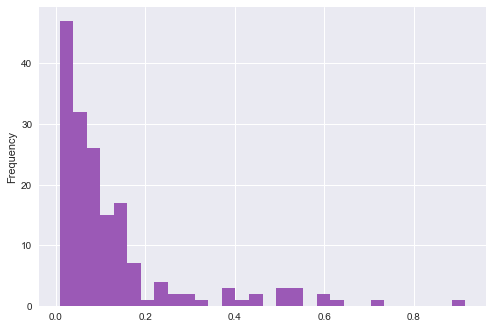

In [10]:
train_data_gc_true["gcMemoryPostAddition"] = train_data_gc_true["finalUsedMemory"] - train_data_gc_true['gcFinalMemory']

train_data_gc_true["gcMemoryPostAddition"].plot.hist(30)

gc_memory_post_addition_pdf = stats.burr.fit(train_data_gc_true['gcMemoryPostAddition'].tolist())
gc_memory_post_addition_pdf

### Fit model to trigger gc

In [11]:
train_gc_initil_memory_pdf = stats.genlogistic.fit(train_data_gc_true["gcInitialMemory"])
train_gc_initil_memory_pdf

(0.044420032509382298, 7.4767761583944861, 0.037450571017435125)

### Fit model for total memory

In [63]:
total_memory_pdf = stats.genlogistic.fit(data["initialUsedMemory"] + data["initialFreeMemory"])
total_memory_pdf

(0.17690242577820864, 7.9159938408067152, 0.040520674120296571)

### Build a simple model

In [85]:
pred_data = pd.read_csv("gcPredictionFile.csv")
pred_data['tokenId'] = pd.to_numeric(pred_data['query token'].str.split("_").str[1])
pred_data['gcRun'] = pred_data['gcRun'].apply(str)

for idx, row in pred_data.iterrows():
    token = tokens[tokens['tokenId'] == row['tokenId']]
    token_pdf = token['pdf'].tolist()[0]
    token_memory = stats.dgamma.rvs(token_pdf[0], loc=token_pdf[1], scale=token_pdf[2])
    if idx == 0:
        gc_inital_memory = token_memory + row['initialUsedMemory']
    else:
        gc_inital_memory = token_memory + final_memory
    gc_probablity = stats.genlogistic.pdf(gc_inital_memory, train_gc_initil_memory_pdf[0], 
                                          loc=train_gc_initil_memory_pdf[1],
                                          scale=train_gc_initil_memory_pdf[2])
    total_memory = stats.genlogistic.rvs(total_memory_pdf[0],
                                         total_memory_pdf[1],
                                         total_memory_pdf[2])
    gc_run = (gc_probablity > 0.2 or gc_inital_memory > 7)
    if gc_run:
        memory_released = stats.genlogistic.rvs(gc_memory_released_pdf[0],
                                                loc=gc_memory_released_pdf[1],
                                                scale=gc_memory_released_pdf[2])
        post_memory_addition = stats.burr.rvs(gc_memory_post_addition_pdf[0],
                                              gc_memory_post_addition_pdf[1],
                                              gc_memory_post_addition_pdf[2])
        final_memory = gc_inital_memory - memory_released + post_memory_addition
    else:
        final_memory = gc_inital_memory

    if gc_run:
        pred_data.set_value(idx, 'gcRun', "TRUE")
    else:
        pred_data.set_value(idx, 'gcRun', "FALSE")

    pred_data.set_value(idx, 'serialNum', idx + 1)
    
    if idx != pred_data.shape[0] - 1:
        pred_data.set_value(idx+1, 'initialFreeMemory', 7.6975773737945055 - final_memory)


pred_data['serialNum'] = pred_data['serialNum'].astype(int)

del pred_data['tokenId']
del pred_data['initialUsedMemory']
del pred_data['cpuTimeTaken']
del pred_data['query token']

In [86]:
pred_data.to_csv("predictions.csv", index=False, columns=["serialNum","initialFreeMemory","gcRun"])
pred_data

,initialFreeMemory,gcRun,serialNum
0,2.774299,FALSE,1
1,3.351536,FALSE,2
2,3.304926,FALSE,3
3,3.243284,FALSE,4
4,3.115501,FALSE,5
5,2.878911,FALSE,6
6,2.862262,FALSE,7
7,2.804466,FALSE,8
8,2.659447,FALSE,9
9,2.578179,FALSE,10
